In [27]:
#pip install pennylane


In [28]:
#pip install pennylane-qiskit

In [29]:
#pip install --upgrade pennylane numpy scikit-learn

In [78]:

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pennylane as qml
#qiskit libraries
from qiskit import Aer
from qiskit.primitives import Sampler
from qiskit import execute
from qiskit import QuantumCircuit, transpile, assemble
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import decomposition



In [31]:
# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

In [32]:
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred, average='macro')
svm_recall = recall_score(y_test, svm_pred, average='macro')
svm_f1 = f1_score(y_test, svm_pred, average='macro')

In [33]:
# Print the metrics for both models
print("SVM Accuracy:", svm_accuracy)
print("SVM Precision:", svm_precision)
print("SVM Recall:", svm_recall)
print("SVM F1 Score:", svm_f1)

SVM Accuracy: 0.9666666666666667
SVM Precision: 0.9666666666666667
SVM Recall: 0.9696969696969697
SVM F1 Score: 0.9665831244778613


In [34]:
# QSVM
n_qubits = 4  # Number of qubits matches the number of features
dev = qml.device("qiskit.aer", wires=n_qubits)

@qml.qnode(dev)
def qsvm_circuit(x, weights):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.Rot(*weights[0], wires=0)
    qml.Rot(*weights[1], wires=1)
    #qml.Rot(*weights[2], wires=2)
    #qml.Rot(*weights[3], wires=3)
    return [qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))]

def qsvm_cost(weights):
    predictions = np.asarray([qsvm_circuit(x, weights) for x in X_train])
    dot_product = np.dot(predictions.T, y_train) / len(X_train)
    return np.sum(np.sin(1 - dot_product))

# Randomly initialize weights
weights = np.random.uniform(size=(4, 3))
weights = qml.numpy.array(weights)
print(weights)

[[0.66773655 0.16586622 0.61839875]
 [0.59046906 0.10285846 0.93489667]
 [0.17510672 0.95349477 0.48489324]
 [0.50141153 0.50238681 0.31910546]]


In [35]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
print(opt)

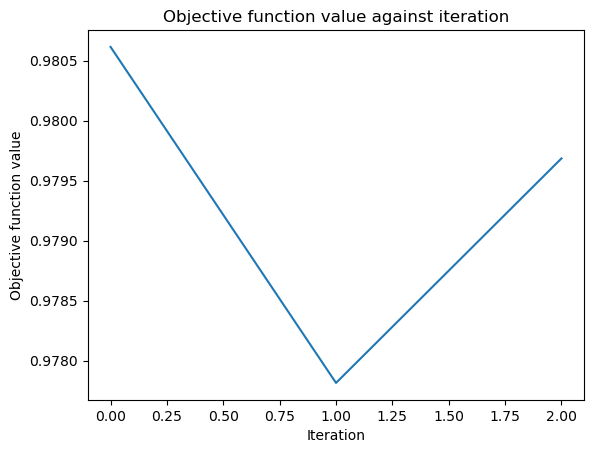

In [36]:
from IPython.display import clear_output
# Variables to store the training progress
loss_values = []
# Optimization loop with plotting during training
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Training Progress')

# Optimization loop with plotting during training
for it in range(3):
    weights = opt.step(qsvm_cost, weights)
    loss = qsvm_cost(weights)
    loss_values.append(loss)
    print(f"Iteration {it+1}: Loss = {loss}")
    
    # Update and display the plot
    clear_output(wait=True)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(loss_values)), loss_values)
    plt.show()

# Final plot of the training progress
clear_output(wait=True)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(loss_values)), loss_values)
plt.show()

In [37]:
# Test the models on the same testing set
qsvm_pred = np.argmax([qsvm_circuit(x, weights) for x in X_test], axis=1)

# Calculate evaluation metrics for both models


qsvm_accuracy = accuracy_score(y_test, qsvm_pred)
qsvm_precision = precision_score(y_test, qsvm_pred, average='macro', zero_division=0)
qsvm_recall = recall_score(y_test, qsvm_pred, average='macro', zero_division=0)
qsvm_f1 = f1_score(y_test, qsvm_pred, average='macro')

In [38]:
print("QSVM Accuracy:", qsvm_accuracy)
print("QSVM Precision:", qsvm_precision)
print("QSVM Recall:", qsvm_recall)
print("QSVM F1 Score:", qsvm_f1)

QSVM Accuracy: 0.2
QSVM Precision: 0.07407407407407407
QSVM Recall: 0.2222222222222222
QSVM F1 Score: 0.1111111111111111


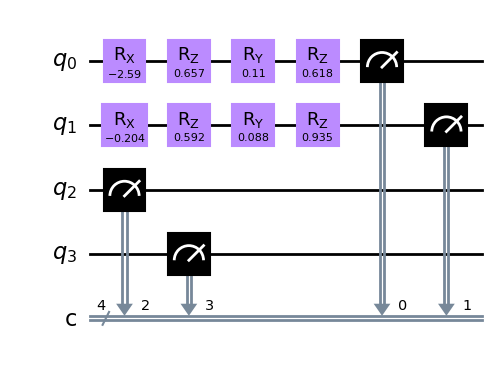

In [39]:
dev._circuit.draw(output="mpl")

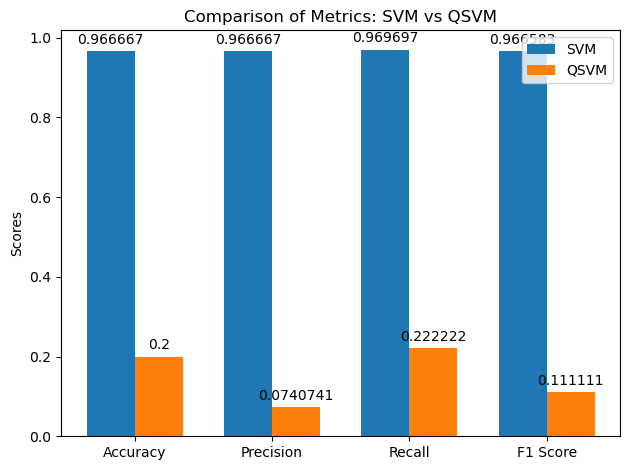

In [40]:
# Bar chart
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
svm_scores = [svm_accuracy, svm_precision, svm_recall, svm_f1]
qsvm_scores = [qsvm_accuracy, qsvm_precision, qsvm_recall, qsvm_f1]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, svm_scores, width, label='SVM')
rects2 = ax.bar(x + width/2, qsvm_scores, width, label='QSVM')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics: SVM vs QSVM')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [41]:
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/e7eef170-5f0d-42c3-a6c6-9ae33096de85/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/Quantamunia",
    location = "West Europe")

In [45]:
backend = provider.get_backend("ionq.simulator")